[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/indicium15/ml-workshop/blob/main/koh-et-al.ipynb)

# Install Dependencies
| Package      | Description                                   | Documentation Link |
|--------------|-----------------------------------------------|--------------------|
| openpyxl     | Read Excel Files | [openpyxl docs](https://openpyxl.readthedocs.io/en/stable/) |
| pandas       | Data analysis and manipulation library        | [pandas docs](https://pandas.pydata.org/docs/) |
| scikit-learn | Machine learning library for Python, including clustering algorithms | [scikit-learn docs](https://scikit-learn.org/stable/) |
| matplotlib   | 2D plotting library | [matplotlib docs](https://matplotlib.org/stable/) |
| seaborn      | Data visualization library | [seaborn docs](https://seaborn.pydata.org/) |
| gdown      | Package to download files from Google Drive | [gdown github](https://github.com/wkentaro/gdown) |


In [2]:
! pip install pandas openpyxl scikit-learn matplotlib seaborn gdown

# Download Data from Google Drive

In [14]:
import gdown
import os

# Make sure data folder exists
os.makedirs("data", exist_ok=True)

# PDF file
pdf_file_id = "1P1WA_88T_zjcrF13DijNs_zkjC8xOEWg"
gdown.download(id=pdf_file_id, output="data/koh-et-al.pdf", quiet=True)

# Excel File
! wget "https://docs.google.com/spreadsheets/d/1V2oDp0BScKpgrC1C7uZWPVU-dOb6y17D14BfL19iI-o/export?format=xlsx" -O data/koh-et-al-2024-data.xlsx

--2025-08-18 20:47:51--  https://docs.google.com/spreadsheets/d/1V2oDp0BScKpgrC1C7uZWPVU-dOb6y17D14BfL19iI-o/export?format=xlsx
Resolving docs.google.com (docs.google.com)... 142.251.10.139, 142.251.10.113, 142.251.10.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-14-2c-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/p7f8u7vjsp4gfro5c4pe1quc5c/1755521270000/102645366291810711303/*/1V2oDp0BScKpgrC1C7uZWPVU-dOb6y17D14BfL19iI-o?format=xlsx [following]
--2025-08-18 20:47:51--  https://doc-14-2c-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/p7f8u7vjsp4gfro5c4pe1quc5c/1755521270000/102645366291810711303/*/1V2oDp0BScKpgrC1C7uZWPVU-dOb6y17D14BfL19iI-o?format=xlsx
Resolving doc-14-2c-sheets.googleusercontent.com (doc-14-2c-sheets.googleusercontent.com)... 74.125.130.132
Connecting to doc-14-2c-sheets.googleusercontent.com (doc-14-2c-she

# Data Loading
In the Excel File, the raw data is stored in the first sheet. Additionally, we must not read the information stored in:
1. Column A, as it contains the clustering results, and
2. Rows 57-60, as they are not relevant to the analysis.

Using Pandas `read_excel` function, which requires the python package `openpyxl`, we can easily load the data into memory. 

In [4]:
import pandas as pd

def load_vps_cluster_data(filepath="./data/koh-et-al-2024-data.xlsx"):
    """
    Loads and preprocesses the 'data_clustered_stats' sheet from the specified Excel file.

    - Reads only the 'data_clustered_stats' sheet
    - Skips the first column (column A)
    - Reads up to row 55
    
    Returns:
        pd.DataFrame: The cleaned dataframe
    """
    df = pd.read_excel(
        filepath,
        sheet_name="data_clustered_stats",
        nrows=55
    )
    # Filter out first column (index 0)
    df = df.iloc[:, 1:]
    return df

After calling the function to load the data, we can check the `shape` of the data, against our Excel sheet.

`shape` is represented as `(number of rows, number of columns)`.

We can also use the `.head()` function to inspect the first five rows of data.

In [5]:
df = load_vps_cluster_data()
print(df.shape)
df.head()

(54, 28)


,Use of first name,hustle,Scold,Silence,management,physical assistance,pre-instruction,pre-instruction Values,concurrent instructions,concurrent instructions Values,...,positive modelling values,uncodable,negative modeling values,positive modelling transfer,pre instruction transfer,post instruction transfer,concurrent instruction transfer,questioning transfer,negative modelling transfer,praise transfer
0,0,0,0,50,43,10,0,0,0,0,...,0.0,0,0,0,0,1,0,0,0,0
1,6,9,2,19,7,73,0,14,0,21,...,0.0,0,0,0,0,0,0,0,0,0
2,6,0,2,43,9,48,7,12,2,104,...,0.0,0,0,0,0,0,0,0,0,0
3,1,20,0,30,2,23,0,11,0,13,...,0.0,0,0,0,0,0,0,0,0,0
4,4,10,2,8,18,39,3,29,2,53,...,0.0,0,0,0,0,0,0,0,0,0


# Data Cleaning
An important part of data pre-processing is filtering out NaN (empty) cells. If not handled, they can cause errors in downstream machine learning tasks.

Thankfully, it is very easy to check for these values using the `isna()` method in Pandas, and find their locations.

In [6]:
# Check for NaN values and their locations and columns
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns[nan_columns].index.tolist())
nan_locations = df.isna().any(axis=1)
print("Rows with NaN values:")
print(df[nan_locations])

Columns with NaN values:
['post instructions', 'positive modelling values']
Rows with NaN values:
    Use of first name  hustle  Scold  Silence  management  \
15                  1       1      0       50           2   
42                  0       4      1       59           0   
49                 13      87      6        0          35   

    physical assistance  pre-instruction  pre-instruction Values  \
15                   22                7                       5   
42                   44               18                      14   
49                   29               39                      15   

    concurrent instructions  concurrent instructions Values  ...  \
15                        0                              23  ...   
42                        1                              22  ...   
49                        0                              39  ...   

    positive modelling values  uncodable  negative modeling values  \
15                        0.0          0 

In this case, we can safely assume that an empty cell reflects a zero value. Again, pandas makes this very easy with the `fillna()` function, and we can choose what value to fill the empty cells with as well.

In [7]:
# Fill NaN values with 0
df = df.fillna(0)

# Data Visualization
Pandas and Matplotlib are powerful tools for performing exploratory data analysis and visualizing results.

For example, here, with just a few lines of code, we can create histograms for each column and plot the results.

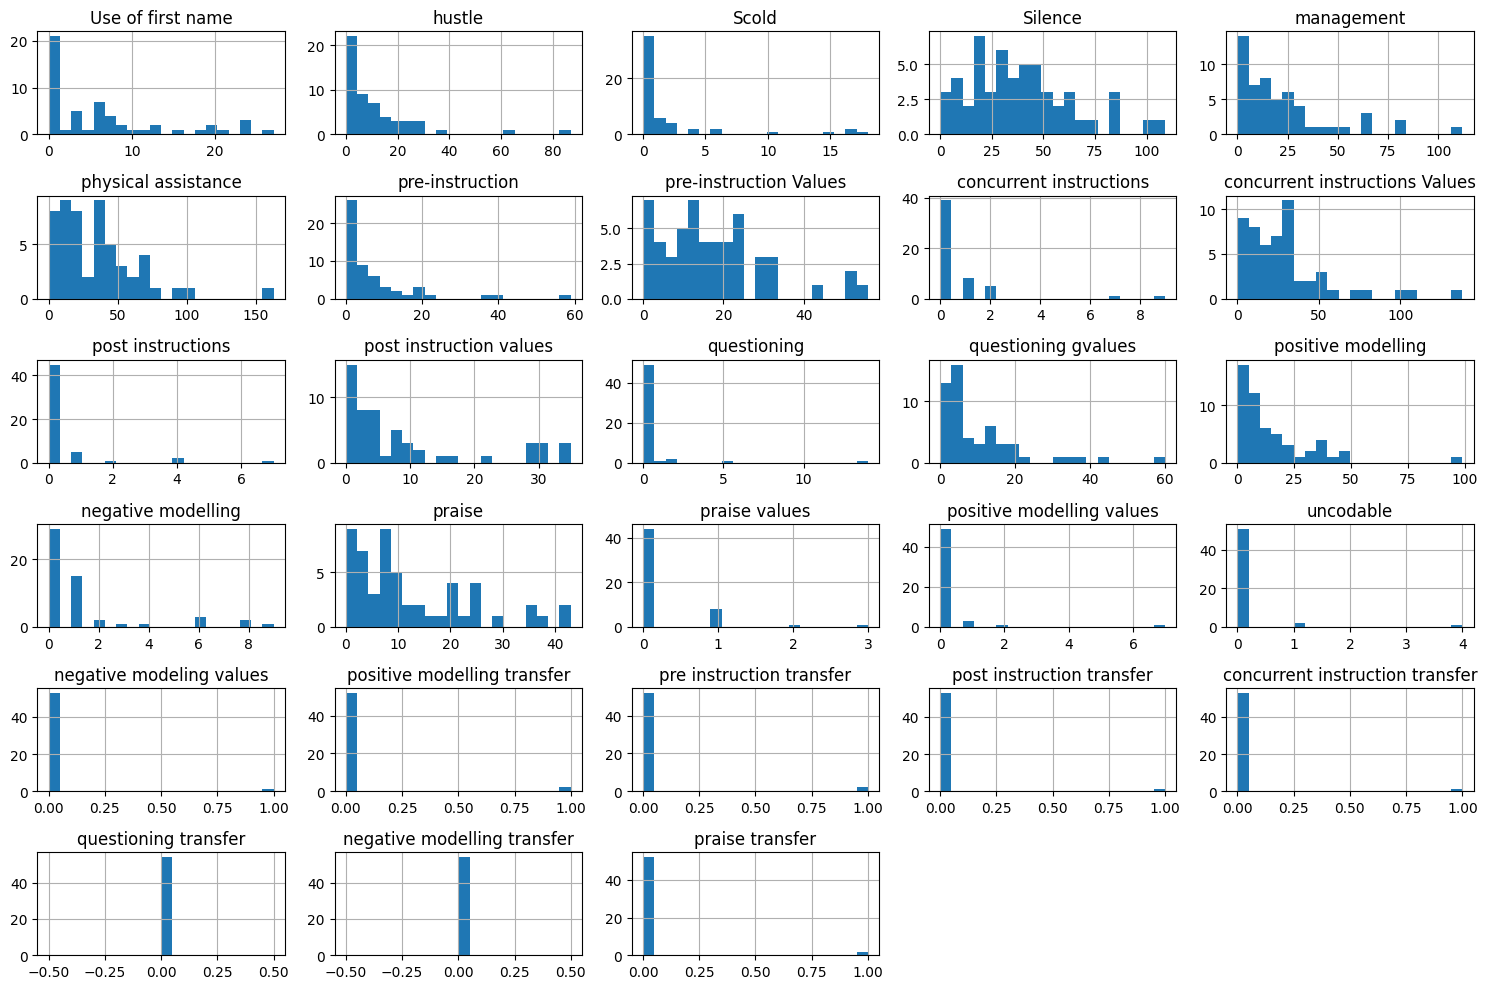

In [8]:
import matplotlib.pyplot as plt
# Create histograms for each column
df.hist(figsize=(15,10), bins=20)
# Visualize distributions for each column
plt.tight_layout()
plt.show()

# K-Means Clustering with Calinski–Harabasz Optimization

In this section, we:

1. Determine the optimal number of clusters (`k`) 
   - We run K-Means for a range of possible `k` values (default: 2–9).
   - For each `k`, we compute the **Calinski–Harabasz (CH) score**, which measures how well the data is separated into clusters (higher = better separation).
   - We plot the CH scores so you can visually inspect which `k` performs best.
   - The function prints and returns the `k` with the highest CH score.

2. Run K-Means clustering  
   - If `k` is not provided, we automatically select the best `k` using the CH score.
   - We fit K-Means to the dataset and assign each sample to a cluster.
   - The cluster labels are added as a new column (`Cluster`) in the DataFrame.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

def find_optimal_k(data, k_range=range(2, 10)):
    """
    Use Calinski-Harabasz score to find optimal number of clusters.
    """
    scores = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(data)
        score = calinski_harabasz_score(data, labels)
        scores.append(score)
    
    # Plot CH scores
    plt.plot(k_range, scores, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Calinski-Harabasz Score")
    plt.title("Optimal k via Calinski-Harabasz")
    plt.grid(True)
    plt.show()
    
    # Return best k
    best_k = k_range[scores.index(max(scores))]
    print(f"Optimal k based on CH score: {best_k}")
    return best_k

def cluster_vps_data(df, k=None):
    """
    Full pipeline: choose optimal k (if not given), cluster with KMeans.
    
    Returns:
        clustered_df: dataframe with cluster labels
        model: fitted KMeans model
    """
    if k is None:
        k = find_optimal_k(df)
    
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(df)
    
    clustered_df = df.copy()
    clustered_df['Cluster'] = labels
    
    return clustered_df, model

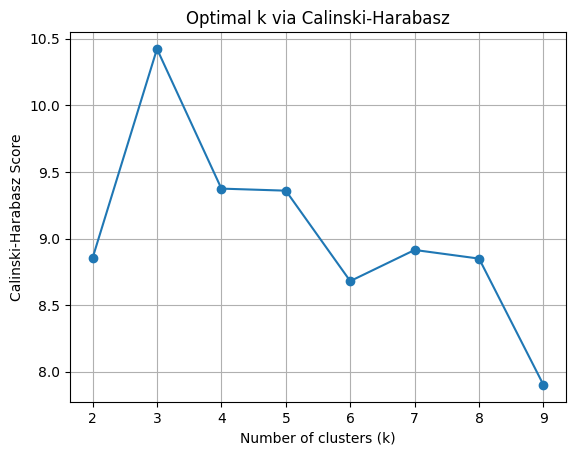

Optimal k based on CH score: 3
Cluster
0    31
1    12
2    11
Name: count, dtype: int64


In [10]:
clustered_df, kmeans_model = cluster_vps_data(df)
# View cluster sizes
print(clustered_df['Cluster'].value_counts())

# Visualize Clustering Results
After creating a new `Cluster` column in our DataFrame, we can summarize and visualize the characteristics of each cluster to understand how they differ.

### Group Data with `pandas.groupby`
- `groupby('Cluster')` groups the dataset by the cluster labels we assigned earlier.
- Using `.mean(numeric_only=True)` calculates the average value of each numeric feature for every cluster.
- Simlarly, `.std(numeric_only=True)` calculates the standard deviation of each feature for every cluster.

- These summaries are helpful for profiling clusters:  
  - High mean: feature is typical in that cluster.  
  - Low mean: feature is uncommon in that cluster.  
  - High std: feature usage varies widely between members of the cluster.  
  - Low std: feature usage is consistent in that cluster.

The code block below plots a grid of bar charts, where each row corresponds to one feature, and each column corresponds to one cluter. Bars represent cluster means, while the error bars show the standard deviation. This makes it easy to compare profiles across clusters.

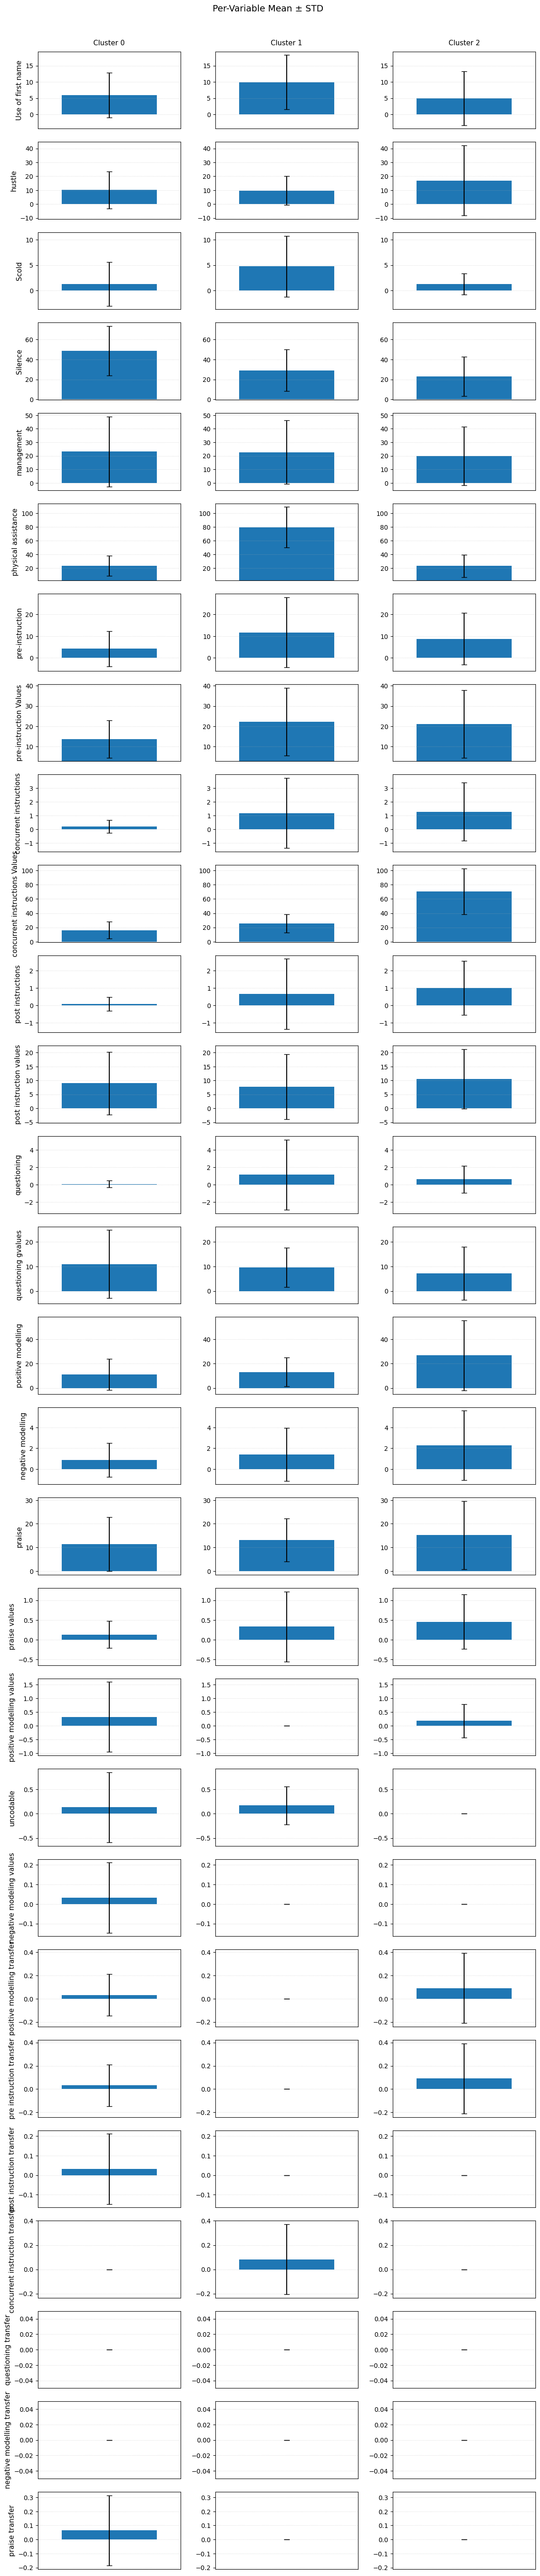

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Compute means & stds per cluster
cluster_means = clustered_df.groupby('Cluster').mean(numeric_only=True)
cluster_stds  = clustered_df.groupby('Cluster').std(numeric_only=True)

# Order axes
clusters = cluster_means.index.tolist()
variables = cluster_means.columns.tolist()

n_rows = len(variables)   # Variables as rows
n_cols = len(clusters)    # Clusters as columns

# Figure size big enough to fit all variables
fig_w = max(12, n_cols * 2.0)
fig_h = max(6, n_rows * 2.0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

for i, var in enumerate(variables):
    col_min = (cluster_means[var] - cluster_stds[var]).min()
    col_max = (cluster_means[var] + cluster_stds[var]).max()
    margin = 0.05 * (col_max - col_min if col_max > col_min else 1.0)
    col_ylim = (col_min - margin, col_max + margin)

    for j, cl in enumerate(clusters):
        ax = axes[i, j]
        mean_val = cluster_means.loc[cl, var]
        std_val  = cluster_stds.loc[cl, var]

        ax.bar(0, mean_val, yerr=std_val, capsize=4)
        ax.set_ylim(col_ylim)
        ax.set_xticks([])
        ax.set_xlim(-0.6, 0.6)

        if i == 0:
            ax.set_title(f"Cluster {cl}", fontsize=11, pad=10)
        if j == 0:
            ax.set_ylabel(var, fontsize=11)

        ax.yaxis.grid(True, linestyle=":", alpha=0.5)

fig.suptitle("Per-Variable Mean ± STD", fontsize=14, y=1.005)
plt.tight_layout()
plt.show()


/var/folders/k4/w9dbm1s13dl19lv4d6wt6lqc0000gn/T/ipykernel_1326/1721758597.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.22222222 0.22222222 0.03703704 0.14814815 0.74074074
 0.66666667 0.74074074 0.11111111 0.03703704 0.         0.25925926
 0.22222222 0.03703704 0.22222222 0.03703704 0.22222222 0.18518519
 0.33333333 0.         0.88888889 0.22222222 0.25925926 0.
 0.48148148 0.03703704 0.         0.         0.22222222 0.03703704
 0.         0.         0.77777778 0.11111111 0.85185185 0.40740741
 0.         0.25925926 0.33333333 0.         0.         0.11111111
 0.         0.55555556 0.2962963  1.         0.14814815 0.85185185
 0.         0.48148148 0.         0.07407407 0.         0.37037037]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X[:] = scaler.fit_transform(X.values)
/var/folders/k4/w9dbm1s13dl19lv4d6wt6lqc0000gn/T/ipykernel_1326/1721758597.p

Selected K mode: Manual (use slider)
Chosen k: 3

Cluster sizes:
Cluster
0     6
1     7
2    41
Name: count, dtype: int64 



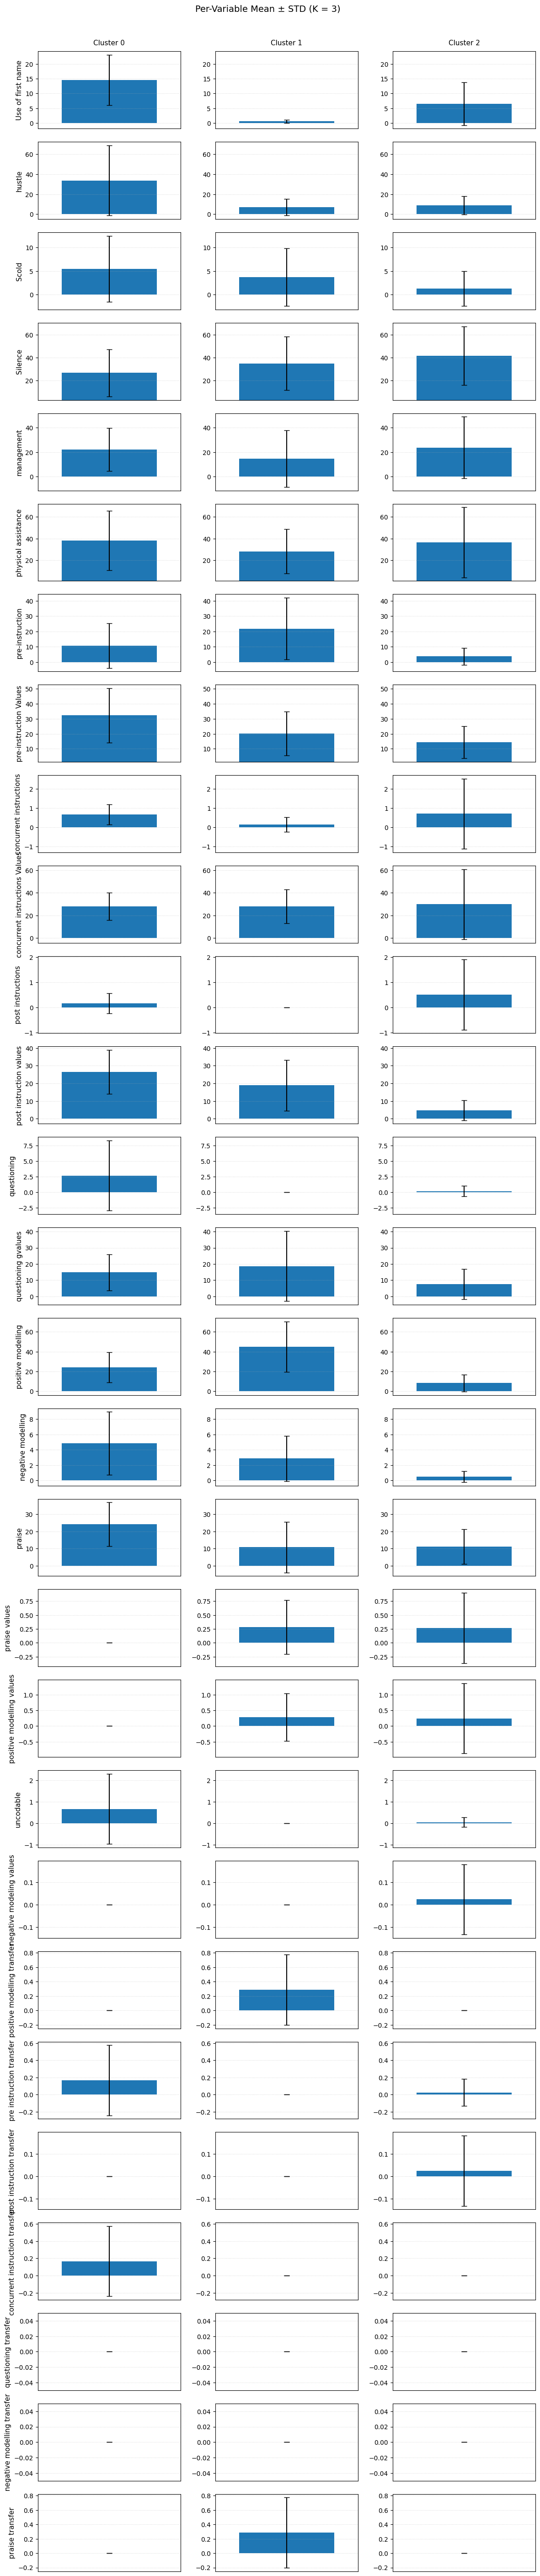

In [ ]:
#@title Try it yourself: K-Means with manual or automatic K selection {display-mode: "form"}
#@markdown Choose how to select **K** (manual or via Elbow / Silhouette / Calinski–Harabasz), optionally normalize features to 0–1, and then press ▶️.
select_k_mode = "Manual (use slider)"  #@param ["Manual (use slider)", "Auto: Elbow Method", "Auto: Silhouette Score", "Auto: Calinski–Harabasz Index"]
k_manual = 3  #@param {type:"slider", min:2, max:12, step:1}
k_min = 2  #@param {type:"slider", min:2, max:2, step:1}
k_max = 10  #@param {type:"slider", min:3, max:20, step:1}
min_max_normalization = True  #@param {type:"boolean"}
random_state = 42  #@param {type:"number"}

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# --------- Input dataframe expected: df (numeric columns will be used) ----------
if 'df' not in globals():
    raise RuntimeError("This cell expects a pandas DataFrame named `df` to exist.")

# Keep only numeric columns for clustering
X = df.select_dtypes(include=[np.number]).copy()
if X.shape[1] == 0:
    raise ValueError("No numeric columns found in `df` to run k-means.")

# Optional normalization
if min_max_normalization:
    scaler = MinMaxScaler()
    X = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )


n_samples = X.shape[0]
if k_max >= n_samples:
    k_max = max(2, n_samples - 1)  # avoid invalid k
if k_min >= k_max:
    k_min = max(2, min(k_max - 1, 2))

def run_kmeans(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    labels = km.fit_predict(X)
    return km, labels

# ---------------------- Choose K ----------------------
chosen_k = None
score_curve = None
score_label = None
k_values = list(range(k_min, k_max + 1))

if select_k_mode == "Manual (use slider)":
    chosen_k = int(k_manual)
else:
    scores = []
    for k in k_values:
        km, lbl = run_kmeans(X, k, random_state=random_state)
        if select_k_mode == "Auto: Elbow Method":
            # WCSS (inertia) — lower is better; elbow ~ sharp drop change
            scores.append(km.inertia_)
            score_label = "Within-Cluster SSE (Inertia) ↓"
        elif select_k_mode == "Auto: Silhouette Score":
            # Average silhouette — higher is better
            s = silhouette_score(X, lbl)
            scores.append(s)
            score_label = "Silhouette Score ↑"
        else:  # Auto: Calinski–Harabasz Index
            # CH index — higher is better
            s = calinski_harabasz_score(X, lbl)
            scores.append(s)
            score_label = "Calinski–Harabasz Index ↑"
    score_curve = np.array(scores)

    # Pick K:
    if select_k_mode == "Auto: Elbow Method":
        # Simple elbow heuristic via first-derivative drop (argmin of second derivative)
        # Compute discrete second derivative and pick its minimum (largest curvature)
        y = score_curve
        # Protect against short ranges
        if len(k_values) >= 3:
            second_deriv = np.diff(y, n=2)
            idx = np.argmin(second_deriv) + 1  # center index for second derivative
            chosen_k = k_values[idx]
        else:
            chosen_k = k_values[np.argmin(np.gradient(y))]  # fallback
    else:
        # For Silhouette / CH pick the argmax
        chosen_k = k_values[int(np.argmax(score_curve))]

print(f"Selected K mode: {select_k_mode}")
print(f"Chosen k: {chosen_k}")

# ---------------------- Final Clustering ----------------------
final_kmeans, final_labels = run_kmeans(X, chosen_k, random_state=random_state)

# Build clustered_df to mirror your original pipeline
clustered_df = df.copy()
clustered_df['Cluster'] = final_labels

# Show cluster sizes
print("\nCluster sizes:")
print(clustered_df['Cluster'].value_counts().sort_index(), "\n")

# ---------------------- (Optional) Score Visualization ----------------------
if select_k_mode != "Manual (use slider)" and score_curve is not None:
    plt.figure(figsize=(7, 4.5))
    plt.plot(k_values, score_curve, marker='o')
    if select_k_mode == "Auto: Elbow Method":
        plt.title("Elbow Method: Inertia vs K")
        plt.ylabel("Inertia (WCSS) ↓")
    elif select_k_mode == "Auto: Silhouette Score":
        plt.title("Silhouette Score vs K")
        plt.ylabel("Average Silhouette ↑")
    else:
        plt.title("Calinski–Harabasz Index vs K")
        plt.ylabel("CH Index ↑")
    plt.xlabel("K (number of clusters)")
    # Mark chosen K
    try:
        idx = k_values.index(chosen_k)
        plt.scatter([chosen_k], [score_curve[idx]], s=120, zorder=3)
    except ValueError:
        pass
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ---------------------- New Visualization: Mean ± STD Grid ----------------------
# Compute means & stds per cluster
cluster_means = clustered_df.groupby('Cluster').mean(numeric_only=True)
cluster_stds  = clustered_df.groupby('Cluster').std(numeric_only=True)

# Order axes
clusters = cluster_means.index.tolist()
variables = cluster_means.columns.tolist()

n_rows = len(variables)   # Variables as rows
n_cols = len(clusters)    # Clusters as columns

# Figure size big enough to fit all variables
fig_w = max(12, n_cols * 2.0)
fig_h = max(6,  n_rows * 2.0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), squeeze=False)

for i, var in enumerate(variables):
    # Shared y-limits across clusters for this variable
    col_min = (cluster_means[var] - cluster_stds[var]).min()
    col_max = (cluster_means[var] + cluster_stds[var]).max()
    margin = 0.05 * (col_max - col_min if col_max > col_min else 1.0)
    col_ylim = (col_min - margin, col_max + margin)

    for j, cl in enumerate(clusters):
        ax = axes[i, j]
        mean_val = float(cluster_means.loc[cl, var])
        std_val  = float(cluster_stds.loc[cl, var]) if not np.isnan(cluster_stds.loc[cl, var]) else 0.0

        ax.bar(0, mean_val, yerr=std_val, capsize=4)
        ax.set_ylim(col_ylim)
        ax.set_xticks([])
        ax.set_xlim(-0.6, 0.6)

        if i == 0:
            ax.set_title(f"Cluster {cl}", fontsize=11, pad=10)
        if j == 0:
            ax.set_ylabel(var, fontsize=11)

        ax.yaxis.grid(True, linestyle=":", alpha=0.5)

fig.suptitle(f"Per-Variable Mean ± STD (K = {chosen_k})", fontsize=14, y=1.005)
plt.tight_layout()
plt.show()
